In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

fee = 1.5
delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=20)
validation_date = datetime.date(year=2016, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')

In [4]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


In [5]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [6]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

In [7]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

In [8]:
def calculate_target(row):
    global fee, delta, stop_loss, treshold
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + treshold:
        if volatility > 0:
            return 1
            # if row['Open'] - row['Low'] > stop_loss:
            #     return 0
            # else:
            #     return 1
        else:
            return (-1)
            # if row['High'] - row['Open'] > stop_loss:
            #     return 0
            # else:
            #     return (-1)
    else:
        return 0
    # df['target'] = df.apply(calculate_target, axis=1)
    # df.target = df.target.shift(-1)
    return df


def create_trade_outcomes(df, contracts, treshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(calculate_target, axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [9]:
treshold = 300
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, treshold)
gold_gains.head(20)

            gains     Open     High      Low   Settle  target
Date                                                         
1996-01-02  342.0  38830.0  39200.0  38800.0  39190.0       1
1996-01-03  361.0  39240.0  39630.0  39220.0  39620.0       1
1996-01-04   95.0  39440.0  39580.0  39410.0  39540.0       0
1996-01-05 -123.5  39780.0  39920.0  39620.0  39650.0       0
1996-01-09  104.5  39580.0  39710.0  39480.0  39690.0       0


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,361.0,39240.0,39630.0,39220.0,39620.0,1.0
1996-01-03,95.0,39440.0,39580.0,39410.0,39540.0,0.0
1996-01-04,-123.5,39780.0,39920.0,39620.0,39650.0,0.0
1996-01-05,104.5,39580.0,39710.0,39480.0,39690.0,0.0
1996-01-09,228.0,39780.0,40300.0,39780.0,40020.0,0.0
1996-01-10,-66.5,40000.0,40060.0,39880.0,39930.0,0.0
1996-01-11,-361.0,40050.0,40090.0,39650.0,39670.0,-1.0
1996-01-12,133.0,39470.0,39630.0,39400.0,39610.0,0.0
1996-01-15,142.5,39730.0,39890.0,39720.0,39880.0,0.0


In [10]:
get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,388.3,392.0,388.0,391.9,41453.0,57500.0,2.500000,1.0
1996-01-03,392.4,396.3,392.2,396.2,102217.0,79518.0,1.204819,0.0
1996-01-04,394.4,395.8,394.1,395.4,37223.0,83787.0,10.843373,0.0
1996-01-05,397.8,399.2,396.2,396.5,49601.0,89355.0,24.107143,0.0
1996-01-09,395.8,397.1,394.8,396.9,27499.0,90634.0,20.535714,0.0
1996-01-10,397.8,403.0,397.8,400.2,74480.0,103163.0,18.666667,0.0
1996-01-11,400.0,400.6,398.8,399.3,40319.0,103776.0,24.666667,-1.0
1996-01-12,400.5,400.9,396.5,396.7,45436.0,97237.0,42.000000,0.0
1996-01-15,394.7,396.3,394.0,396.1,32344.0,95690.0,46.000000,0.0


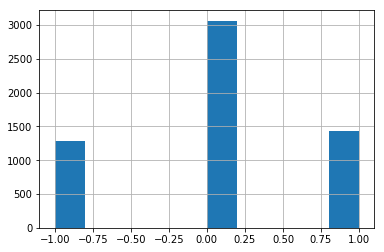

In [11]:
gold['target'].hist()

In [12]:
gold_gains.gains.describe()

count     5780.000000
mean         2.190917
std        903.824695
min     -11390.500000
25%       -237.500000
50%          9.500000
75%        294.500000
max       6555.000000
Name: gains, dtype: float64

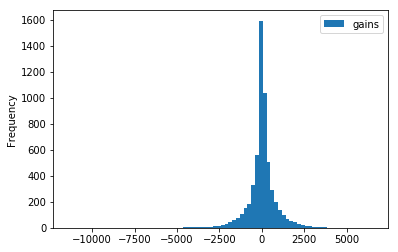

In [13]:
gold_gains[['gains']].plot.hist(bins=80)

In [14]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
treshold = 100
corn_gains = create_trade_outcomes(corn, contracts, treshold)
corn_gains.head(5)

              gains     Open     High      Low   Settle  target
Date                                                           
1996-01-02  106.875  18550.0  18762.5  18512.5  18662.5       1
1996-01-03   47.500  18650.0  18725.0  18512.5  18700.0       0
1996-01-04 -213.750  18675.0  18687.5  18250.0  18450.0      -1
1996-01-05  -11.875  18337.5  18450.0  18275.0  18325.0       0
1996-01-08 -190.000  18225.0  18225.0  18000.0  18025.0      -1


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0,0.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0,-1.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0,0.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0,-1.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5,1.0


In [15]:
corn_gains.gains.describe()

count    5789.000000
mean        2.203101
std       310.165899
min     -1983.125000
25%      -118.750000
50%         0.000000
75%       130.625000
max      1888.125000
Name: gains, dtype: float64

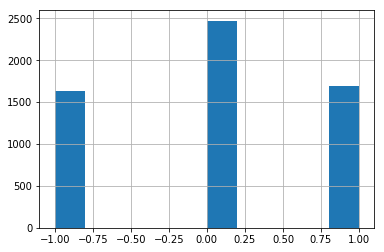

In [16]:
get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

corn.target.hist()

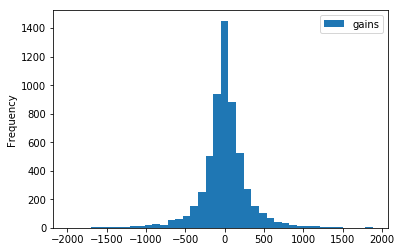

In [17]:
corn_gains[['gains']].plot.hist(bins=40)

In [18]:
corn_gains.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,47.500,18650.0,18725.0,18512.5,18700.0,0.0
1996-01-03,-213.750,18675.0,18687.5,18250.0,18450.0,-1.0
1996-01-04,-11.875,18337.5,18450.0,18275.0,18325.0,0.0
1996-01-05,-190.000,18225.0,18225.0,18000.0,18025.0,-1.0
1996-01-08,368.125,17950.0,18350.0,17950.0,18337.5,1.0
1996-01-09,-249.375,18375.0,18375.0,18100.0,18112.5,-1.0
1996-01-10,-225.625,18112.5,18112.5,17800.0,17875.0,-1.0
1996-01-11,237.500,17887.5,18150.0,17887.5,18137.5,1.0
1996-01-12,142.500,18100.0,18262.5,18075.0,18250.0,1.0


In [19]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
treshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, treshold)
coffee_gains.head(5)

                gains     Open      High      Low    Settle  target
Date                                                               
1996-01-02  -480.9375  34725.0  35550.00  34162.5  34218.75      -1
1996-01-03  1015.3125  34087.5  35400.00  33900.0  35156.25       1
1996-01-04  1727.8125  34875.0  36787.50  34875.0  36693.75       1
1996-01-05  -445.3125  36562.5  37293.75  35925.0  36093.75      -1
1996-01-10   890.6250  35775.0  36843.75  35550.0  36712.50       1


,gains,Open,High,Low,Settle,target
Date,,,,,,
1996-01-02,1015.3125,34087.5,35400.00,33900.00,35156.25,1.0
1996-01-03,1727.8125,34875.0,36787.50,34875.00,36693.75,1.0
1996-01-04,-445.3125,36562.5,37293.75,35925.00,36093.75,-1.0
1996-01-05,890.6250,35775.0,36843.75,35550.00,36712.50,1.0
1996-01-10,1977.1875,36562.5,38812.50,36468.75,38643.75,1.0


In [20]:
coffee_gains.gains.describe()

count     5751.000000
mean        -2.638889
std        968.552015
min     -12842.812500
25%       -213.750000
50%          0.000000
75%        231.562500
max       6929.062500
Name: gains, dtype: float64

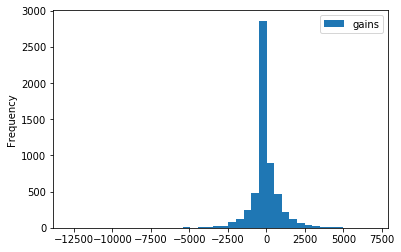

In [21]:
coffee_gains[['gains']].plot.hist(bins=40)

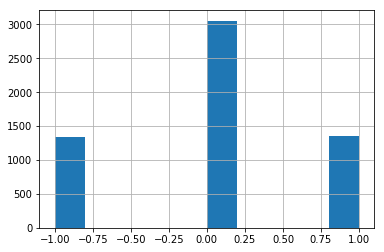

In [22]:
get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
coffee.target.hist()

In [23]:
coffee[coffee.target != 0].head(10)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,wr,target
Date,,,,,,,,
1996-01-02,92.60,94.80,91.10,91.25,5719.0,18717.0,95.945946,1.0
1996-01-03,90.90,94.40,90.40,93.75,6461.0,19257.0,23.863636,1.0
1996-01-04,93.00,98.10,93.00,97.85,8865.0,18918.0,3.246753,-1.0
1996-01-05,97.50,99.45,95.80,96.25,6833.0,18599.0,35.359116,1.0
1996-01-10,95.40,98.25,94.80,97.90,5146.0,18542.0,17.127072,1.0
1996-01-12,103.00,103.85,100.80,102.70,5984.0,17314.0,8.550186,-1.0
1996-01-15,102.70,103.00,98.70,98.95,6128.0,17227.0,36.431227,1.0
1996-01-16,97.75,105.25,97.75,103.90,9918.0,17601.0,9.090909,1.0
1996-01-17,103.05,105.50,103.05,104.30,6504.0,16852.0,7.947020,1.0


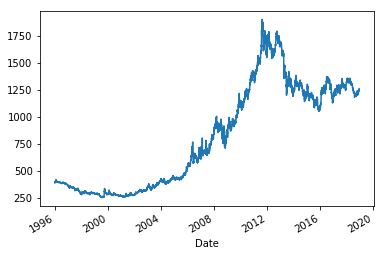

In [24]:
gold['Open'].plot()

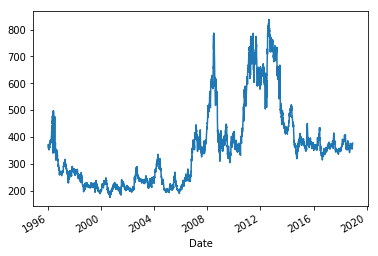

In [25]:
corn['Open'].plot()

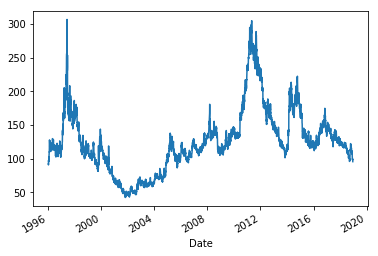

In [26]:
coffee['Open'].plot()

In [27]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        # print(type(idx), type(idx.astype(datetime.datetime)))
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [28]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

In [29]:
gold_data.tail(20)

,0,1,2,3,4,5,6,7,8,9,...,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045
2018-11-23,1213.5,1220.9,1205.6,1211.2,202123.0,199751.0,1212.6,1214.7,1181.2,1189.3,...,0.942235,0.087364,0.916625,0.162104,4,17,11,3,36.363636,0.0
2018-11-26,1212.6,1214.7,1181.2,1189.3,353644.0,164500.0,1189.4,1192.7,1170.3,1178.4,...,0.942235,0.087364,0.916625,0.162104,0,18,11,3,38.277512,-1.0
2018-11-27,1189.4,1192.7,1170.3,1178.4,288389.0,106069.0,1184.4,1197.2,1182.4,1190.8,...,0.942235,0.087364,0.916625,0.162104,1,19,11,3,59.808612,1.0
2018-11-28,1184.4,1197.2,1182.4,1190.8,177818.0,77556.0,1196.6,1197.7,1182.6,1190.8,...,0.916625,0.162104,0.957183,0.139100,2,20,11,3,21.282799,0.0
2018-11-29,1196.6,1197.7,1182.6,1190.8,196186.0,259190.0,1190.7,1196.8,1171.3,1173.9,...,0.916625,0.162104,0.957183,0.139100,3,21,11,3,19.825073,-1.0
2018-11-30,1190.7,1196.8,1171.3,1173.9,236195.0,271613.0,1175.1,1178.4,1162.2,1169.4,...,0.916625,0.162104,0.957183,0.139100,4,22,11,3,31.195335,1.0
2018-12-03,1175.1,1178.4,1162.2,1169.4,216866.0,273896.0,1174.3,1180.3,1168.4,1177.8,...,0.916625,0.162104,0.957183,0.139100,0,1,12,3,0.533333,1.0
2018-12-04,1174.3,1180.3,1168.4,1177.8,169593.0,273718.0,1182.6,1190.2,1158.6,1176.5,...,0.916625,0.162104,0.957183,0.139100,1,2,12,3,0.692841,0.0
2018-12-05,1182.6,1190.2,1158.6,1176.5,212507.0,275782.0,1172.8,1177.1,1168.1,1170.1,...,0.957183,0.139100,0.859876,0.275776,2,3,12,3,12.536443,0.0
2018-12-06,1172.8,1177.1,1168.1,1170.1,131034.0,271766.0,1171.4,1182.3,1167.2,1177.5,...,0.957183,0.139100,0.859876,0.275776,3,4,12,3,18.584071,1.0


In [30]:
gold_data.shape

(5276, 3046)

In [31]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [32]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

In [33]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 3045
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)

    # pca_lst = []
    # pca = PCA(n_components=50, random_state=2234)
    pca = FactorAnalysis(n_components=20, random_state=2234)
    pca.fit(df_train[list(range(3040))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2233)
    # pca.fit(df_train[list(range(2016, 2016 + 504))])
    # pca_lst.append(pca)
    
    # pca = PCA(n_components=2, random_state=2232)
    # pca.fit(df_train[list(range(2016 + 504, 2016 + 1008))])
    # pca_lst.append(pca)

    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 3045
    # df_pca_lst = []
    df_pca = pca.transform(df[list(range(3040))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[1].transform(df[list(range(2016, 2016 + 504))])
    # df_pca_lst.append(df_pca)
    
    # df_pca = pca_lst[2].transform(df[list(range(2016 + 504, 2016 + 1008))])
    # df_pca_lst.append(df_pca)
    
    df_pca = np.concatenate((df_pca, df[list(range(3040,label_index))].values), axis=1)
    return df_pca

In [34]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

In [35]:
# plt.plot(np.cumsum(gold_pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance');

In [36]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [37]:
def plot_pca_relation(pca_data, label_train, x):
    labels = [0, 1, -1]
    labl={-1: 'Short', 0:'No Trade', 1:'Long'}
    plt.figure(1)

    for i in range(x):
        for j in range(i+1, x):
            fig, ax = plt.subplots(figsize=(7,5))
            fig.patch.set_facecolor('white')
            Xax = pca_data[:, i]
            Yax = pca_data[:, j]
            for l in labels:
                ix = np.where(label_train==l)
                ax.scatter(Xax[ix], Yax[ix], label=labl[l])

            plt.xlabel("Principal Component No " + str(i), fontsize=14)
            plt.ylabel("Second Principal Component No " + str(j), fontsize=14)
            plt.legend()
            plt.show()

In [38]:
pca_components = 3

In [39]:
# plot_pca_relation(gold_pca[0].transform(gold_train[list(range(2016))]), gold_label_train, pca_components)

In [40]:
# plot_pca_relation(corn_pca[0].transform(corn_train[list(range(2016))]), corn_label_train, pca_components)

In [41]:
# plot_pca_relation(coffee_pca[0].transform(coffee_train[list(range(2016))]), coffee_label_train, pca_components)

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
import lightgbm as lgb
import xgboost as xgb


X = pca_transform(gold_train, gold_pca)
train_data = lgb.Dataset(X, label=list(map(lambda x: x+1, gold_label_train)), categorical_feature='auto') # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(gold_test, gold_pca)
test_data = lgb.Dataset(X_test, label=list(map(lambda x: x+1, gold_label_test)), categorical_feature='auto')
param = {'num_leaves':31, 'objective':'multiclass'}
# param['metric'] = 'auc'
# param['boosting_type'] = 'gbdt'
# param['metric'] = 'rmse'
param['boosting'] = 'dart'
# param['max_bin'] = 50
# param['metric'] = 'multi_error'
param['metric'] = 'multi_logloss'
param['learning_rate'] = 0.05
param['num_class'] = 3
param['max_bin'] = 50
num_round = 2000
# param = {'boosting_type': 'gbdt',
#          'max_depth' : -1,
#           'objective': 'binary',
#           'nthread': 3, # Updated from nthread
#           'num_leaves': 64,
#           'learning_rate': 0.05,
#           'max_bin': 512,
#           'subsample_for_bin': 200,
#           'subsample': 1,
#           'subsample_freq': 1,
#           'colsample_bytree': 0.8,
#           'reg_alpha': 5,
#           'reg_lambda': 10,
#           'min_split_gain': 0.5,
#           'min_child_weight': 1,
#           'min_child_samples': 5,
#           'scale_pos_weight': 1,
#           'num_class' : 1,
#           'metric' : 'binary_error'}
gold_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

# gold_clf = RandomForestClassifier(n_estimators=150, random_state=1100)
# gold_clf = AdaBoostClassifier(n_estimators=100, random_state=1100, learning_rate=0.1)
# gold_clf = MLPClassifier(hidden_layer_sizes=(100, 3), solver='sgd', random_state=1100)
# gold_clf = MLPRegressor(hidden_layer_sizes=(100, 3), solver='sgd', max_iter=2000, alpha=0.1, random_state=1100)
# sample_weight = list(map(lambda x: 2 if x != 0 else 1, gold_label_train))
# gold_clf.fit(X, gold_label_train)
# gold_clf.fit(X, gold_label_train, sample_weight=sample_weight)

[1]	valid_0's multi_logloss: 1.09444
[2]	valid_0's multi_logloss: 1.09263
[3]	valid_0's multi_logloss: 1.09108
[4]	valid_0's multi_logloss: 1.08945
[5]	valid_0's multi_logloss: 1.08797
[6]	valid_0's multi_logloss: 1.08703
[7]	valid_0's multi_logloss: 1.08634
[8]	valid_0's multi_logloss: 1.08666
[9]	valid_0's multi_logloss: 1.08591
[10]	valid_0's multi_logloss: 1.08475
[11]	valid_0's multi_logloss: 1.08431
[12]	valid_0's multi_logloss: 1.08466
[13]	valid_0's multi_logloss: 1.08378
[14]	valid_0's multi_logloss: 1.08318
[15]	valid_0's multi_logloss: 1.08249
[16]	valid_0's multi_logloss: 1.08211
[17]	valid_0's multi_logloss: 1.0814
[18]	valid_0's multi_logloss: 1.08056
[19]	valid_0's multi_logloss: 1.07982
[20]	valid_0's multi_logloss: 1.07868
[21]	valid_0's multi_logloss: 1.07907
[22]	valid_0's multi_logloss: 1.07933
[23]	valid_0's multi_logloss: 1.07859
[24]	valid_0's multi_logloss: 1.07859
[25]	valid_0's multi_logloss: 1.07891
[26]	valid_0's multi_logloss: 1.07857
[27]	valid_0's multi_l

[262]	valid_0's multi_logloss: 1.09739
[263]	valid_0's multi_logloss: 1.09823
[264]	valid_0's multi_logloss: 1.09898
[265]	valid_0's multi_logloss: 1.10009
[266]	valid_0's multi_logloss: 1.10015
[267]	valid_0's multi_logloss: 1.09972
[268]	valid_0's multi_logloss: 1.10076
[269]	valid_0's multi_logloss: 1.1003
[270]	valid_0's multi_logloss: 1.1009
[271]	valid_0's multi_logloss: 1.10046
[272]	valid_0's multi_logloss: 1.10197
[273]	valid_0's multi_logloss: 1.10225
[274]	valid_0's multi_logloss: 1.10179
[275]	valid_0's multi_logloss: 1.10245
[276]	valid_0's multi_logloss: 1.10199
[277]	valid_0's multi_logloss: 1.10237
[278]	valid_0's multi_logloss: 1.1019
[279]	valid_0's multi_logloss: 1.10246
[280]	valid_0's multi_logloss: 1.10196
[281]	valid_0's multi_logloss: 1.10149
[282]	valid_0's multi_logloss: 1.10309
[283]	valid_0's multi_logloss: 1.10258
[284]	valid_0's multi_logloss: 1.10308
[285]	valid_0's multi_logloss: 1.10416
[286]	valid_0's multi_logloss: 1.10422
[287]	valid_0's multi_loglos

[485]	valid_0's multi_logloss: 1.15417
[486]	valid_0's multi_logloss: 1.15537
[487]	valid_0's multi_logloss: 1.15591
[488]	valid_0's multi_logloss: 1.15663
[489]	valid_0's multi_logloss: 1.15689
[490]	valid_0's multi_logloss: 1.15621
[491]	valid_0's multi_logloss: 1.1556
[492]	valid_0's multi_logloss: 1.15504
[493]	valid_0's multi_logloss: 1.15442
[494]	valid_0's multi_logloss: 1.15468
[495]	valid_0's multi_logloss: 1.15565
[496]	valid_0's multi_logloss: 1.15641
[497]	valid_0's multi_logloss: 1.15719
[498]	valid_0's multi_logloss: 1.15837
[499]	valid_0's multi_logloss: 1.15776
[500]	valid_0's multi_logloss: 1.15849
[501]	valid_0's multi_logloss: 1.1579
[502]	valid_0's multi_logloss: 1.1585
[503]	valid_0's multi_logloss: 1.15942
[504]	valid_0's multi_logloss: 1.15878
[505]	valid_0's multi_logloss: 1.15823
[506]	valid_0's multi_logloss: 1.15864
[507]	valid_0's multi_logloss: 1.159
[508]	valid_0's multi_logloss: 1.15973
[509]	valid_0's multi_logloss: 1.16086
[510]	valid_0's multi_logloss:

[736]	valid_0's multi_logloss: 1.18647
[737]	valid_0's multi_logloss: 1.18599
[738]	valid_0's multi_logloss: 1.18715
[739]	valid_0's multi_logloss: 1.18792
[740]	valid_0's multi_logloss: 1.18862
[741]	valid_0's multi_logloss: 1.18815
[742]	valid_0's multi_logloss: 1.18876
[743]	valid_0's multi_logloss: 1.18893
[744]	valid_0's multi_logloss: 1.19041
[745]	valid_0's multi_logloss: 1.18992
[746]	valid_0's multi_logloss: 1.18941
[747]	valid_0's multi_logloss: 1.19056
[748]	valid_0's multi_logloss: 1.19127
[749]	valid_0's multi_logloss: 1.19076
[750]	valid_0's multi_logloss: 1.19152
[751]	valid_0's multi_logloss: 1.19249
[752]	valid_0's multi_logloss: 1.19197
[753]	valid_0's multi_logloss: 1.19261
[754]	valid_0's multi_logloss: 1.19211
[755]	valid_0's multi_logloss: 1.1924
[756]	valid_0's multi_logloss: 1.19189
[757]	valid_0's multi_logloss: 1.19139
[758]	valid_0's multi_logloss: 1.19231
[759]	valid_0's multi_logloss: 1.19332
[760]	valid_0's multi_logloss: 1.19273
[761]	valid_0's multi_logl

[981]	valid_0's multi_logloss: 1.22834
[982]	valid_0's multi_logloss: 1.22788
[983]	valid_0's multi_logloss: 1.22846
[984]	valid_0's multi_logloss: 1.22919
[985]	valid_0's multi_logloss: 1.22877
[986]	valid_0's multi_logloss: 1.22833
[987]	valid_0's multi_logloss: 1.22781
[988]	valid_0's multi_logloss: 1.22896
[989]	valid_0's multi_logloss: 1.22851
[990]	valid_0's multi_logloss: 1.22816
[991]	valid_0's multi_logloss: 1.22887
[992]	valid_0's multi_logloss: 1.22937
[993]	valid_0's multi_logloss: 1.22894
[994]	valid_0's multi_logloss: 1.2296
[995]	valid_0's multi_logloss: 1.22911
[996]	valid_0's multi_logloss: 1.23051
[997]	valid_0's multi_logloss: 1.23101
[998]	valid_0's multi_logloss: 1.23061
[999]	valid_0's multi_logloss: 1.23123
[1000]	valid_0's multi_logloss: 1.23081
[1001]	valid_0's multi_logloss: 1.23042
[1002]	valid_0's multi_logloss: 1.22994
[1003]	valid_0's multi_logloss: 1.23126
[1004]	valid_0's multi_logloss: 1.23181
[1005]	valid_0's multi_logloss: 1.23269
[1006]	valid_0's mul

[1220]	valid_0's multi_logloss: 1.26424
[1221]	valid_0's multi_logloss: 1.26386
[1222]	valid_0's multi_logloss: 1.26461
[1223]	valid_0's multi_logloss: 1.2642
[1224]	valid_0's multi_logloss: 1.26502
[1225]	valid_0's multi_logloss: 1.26462
[1226]	valid_0's multi_logloss: 1.2652
[1227]	valid_0's multi_logloss: 1.26487
[1228]	valid_0's multi_logloss: 1.26587
[1229]	valid_0's multi_logloss: 1.26636
[1230]	valid_0's multi_logloss: 1.26588
[1231]	valid_0's multi_logloss: 1.26554
[1232]	valid_0's multi_logloss: 1.26522
[1233]	valid_0's multi_logloss: 1.26478
[1234]	valid_0's multi_logloss: 1.26435
[1235]	valid_0's multi_logloss: 1.26392
[1236]	valid_0's multi_logloss: 1.26502
[1237]	valid_0's multi_logloss: 1.26553
[1238]	valid_0's multi_logloss: 1.26513
[1239]	valid_0's multi_logloss: 1.26479
[1240]	valid_0's multi_logloss: 1.26436
[1241]	valid_0's multi_logloss: 1.2639
[1242]	valid_0's multi_logloss: 1.26489
[1243]	valid_0's multi_logloss: 1.26451
[1244]	valid_0's multi_logloss: 1.26585
[12

[1453]	valid_0's multi_logloss: 1.30202
[1454]	valid_0's multi_logloss: 1.30273
[1455]	valid_0's multi_logloss: 1.30331
[1456]	valid_0's multi_logloss: 1.30414
[1457]	valid_0's multi_logloss: 1.30485
[1458]	valid_0's multi_logloss: 1.30584
[1459]	valid_0's multi_logloss: 1.30608
[1460]	valid_0's multi_logloss: 1.30571
[1461]	valid_0's multi_logloss: 1.30699
[1462]	valid_0's multi_logloss: 1.30802
[1463]	valid_0's multi_logloss: 1.30905
[1464]	valid_0's multi_logloss: 1.30855
[1465]	valid_0's multi_logloss: 1.30812
[1466]	valid_0's multi_logloss: 1.30756
[1467]	valid_0's multi_logloss: 1.30721
[1468]	valid_0's multi_logloss: 1.30687
[1469]	valid_0's multi_logloss: 1.30653
[1470]	valid_0's multi_logloss: 1.30725
[1471]	valid_0's multi_logloss: 1.30688
[1472]	valid_0's multi_logloss: 1.30648
[1473]	valid_0's multi_logloss: 1.30607
[1474]	valid_0's multi_logloss: 1.30569
[1475]	valid_0's multi_logloss: 1.30536
[1476]	valid_0's multi_logloss: 1.30497
[1477]	valid_0's multi_logloss: 1.30503


[1697]	valid_0's multi_logloss: 1.35379
[1698]	valid_0's multi_logloss: 1.35444
[1699]	valid_0's multi_logloss: 1.35507
[1700]	valid_0's multi_logloss: 1.35457
[1701]	valid_0's multi_logloss: 1.35483
[1702]	valid_0's multi_logloss: 1.35509
[1703]	valid_0's multi_logloss: 1.35623
[1704]	valid_0's multi_logloss: 1.35702
[1705]	valid_0's multi_logloss: 1.35661
[1706]	valid_0's multi_logloss: 1.35616
[1707]	valid_0's multi_logloss: 1.35584
[1708]	valid_0's multi_logloss: 1.35548
[1709]	valid_0's multi_logloss: 1.35619
[1710]	valid_0's multi_logloss: 1.35581
[1711]	valid_0's multi_logloss: 1.35535
[1712]	valid_0's multi_logloss: 1.35638
[1713]	valid_0's multi_logloss: 1.35597
[1714]	valid_0's multi_logloss: 1.35627
[1715]	valid_0's multi_logloss: 1.35578
[1716]	valid_0's multi_logloss: 1.35695
[1717]	valid_0's multi_logloss: 1.35658
[1718]	valid_0's multi_logloss: 1.35613
[1719]	valid_0's multi_logloss: 1.35578
[1720]	valid_0's multi_logloss: 1.35629
[1721]	valid_0's multi_logloss: 1.35719


[1937]	valid_0's multi_logloss: 1.39082
[1938]	valid_0's multi_logloss: 1.3917
[1939]	valid_0's multi_logloss: 1.3924
[1940]	valid_0's multi_logloss: 1.39284
[1941]	valid_0's multi_logloss: 1.3925
[1942]	valid_0's multi_logloss: 1.39348
[1943]	valid_0's multi_logloss: 1.39372
[1944]	valid_0's multi_logloss: 1.39455
[1945]	valid_0's multi_logloss: 1.39554
[1946]	valid_0's multi_logloss: 1.39506
[1947]	valid_0's multi_logloss: 1.39469
[1948]	valid_0's multi_logloss: 1.39516
[1949]	valid_0's multi_logloss: 1.39563
[1950]	valid_0's multi_logloss: 1.39653
[1951]	valid_0's multi_logloss: 1.3972
[1952]	valid_0's multi_logloss: 1.39674
[1953]	valid_0's multi_logloss: 1.39781
[1954]	valid_0's multi_logloss: 1.3974
[1955]	valid_0's multi_logloss: 1.39716
[1956]	valid_0's multi_logloss: 1.39665
[1957]	valid_0's multi_logloss: 1.39637
[1958]	valid_0's multi_logloss: 1.39603
[1959]	valid_0's multi_logloss: 1.39693
[1960]	valid_0's multi_logloss: 1.39654
[1961]	valid_0's multi_logloss: 1.39609
[1962

In [53]:
X = pca_transform(corn_train, corn_pca)

y = list(map(lambda x: x+1, corn_label_train))
train_data = lgb.Dataset(X, label=y, categorical_feature='auto')
X_test = pca_transform(corn_test, corn_pca)
y_test = list(map(lambda x: x+1, corn_label_test))
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature='auto')
# param = {'num_leaves':31}
# param['objective'] = 'multiclass'
# # param['objective'] = 'multiclass'
# # param['metric'] = 'auc'
# # param['metric'] = 'rmse'
# # param['metric'] = 'multi_error'
# param['metric'] = 'multi_logloss'
# param['num_class'] = 3
# param['max_bin'] = 40
# param['learning_rate'] = 0.025
corn_xgb_use = True
# param['categorical_feature'] = 3040,3041,3042,3043
# num_round = 2000
corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])
# sample_weight = list(map(lambda x: 2 if x != 0 else 1, corn_label_train))
# dtrain = xgb.DMatrix(X, label=list(map(lambda x: x+1, corn_label_train)), weight=sample_weight)
# test_weight = list(map(lambda x: 2 if x != 0 else 1, corn_label_train))
# dtest = xgb.DMatrix(X_test, label=list(map(lambda x: x+1, corn_label_test)), weight=test_weight)
# evallist = [(dtrain, 'train'), (dtest, 'eval')]
# param = {'max_depth': 50, 'eta': 1, 'silent': 1}
# param['booster'] = 'dart'
# param['nthread'] = 3
# param['objective'] = 'multi:softmax'
# param['objective'] = 'reg:linear'
# param['num_class'] = 3
# param['eval_metric'] = 'mlogloss'

# corn_clf = xgb.train(param, dtrain, num_round, evallist)
# corn_clf = xgb.XGBRegressor(max_depth=10, learning_rate=0.1, n_estimators=100, objective='reg:logistic',
#                              booster='dart', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None)
# print(np.unique(list(map(lambda x: (x+1)/2, corn_label_train))))
# corn_clf.fit(X, list(map(lambda x: (x+1)/2, corn_label_train)))

# corn_clf = AdaBoostClassifier(n_estimators=150, learning_rate=0.5, random_state=1100)
# corn_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])
# corn_clf = RandomForestClassifier(n_estimators=100, random_state=1100)
sample_weight = list(map(lambda x: 3 if x != 0 else 1, corn_label_train))
# corn_clf.fit(X, corn_label_train)
# corn_clf.predict(X)

[1]	valid_0's multi_logloss: 1.08731
[2]	valid_0's multi_logloss: 1.08611
[3]	valid_0's multi_logloss: 1.08553
[4]	valid_0's multi_logloss: 1.08502
[5]	valid_0's multi_logloss: 1.08487
[6]	valid_0's multi_logloss: 1.08489
[7]	valid_0's multi_logloss: 1.08495
[8]	valid_0's multi_logloss: 1.08495
[9]	valid_0's multi_logloss: 1.08495
[10]	valid_0's multi_logloss: 1.08456
[11]	valid_0's multi_logloss: 1.08479
[12]	valid_0's multi_logloss: 1.08467
[13]	valid_0's multi_logloss: 1.08465
[14]	valid_0's multi_logloss: 1.0853
[15]	valid_0's multi_logloss: 1.08519
[16]	valid_0's multi_logloss: 1.0851
[17]	valid_0's multi_logloss: 1.08541
[18]	valid_0's multi_logloss: 1.08544
[19]	valid_0's multi_logloss: 1.08565
[20]	valid_0's multi_logloss: 1.08603
[21]	valid_0's multi_logloss: 1.08571
[22]	valid_0's multi_logloss: 1.0859
[23]	valid_0's multi_logloss: 1.08649
[24]	valid_0's multi_logloss: 1.0873
[25]	valid_0's multi_logloss: 1.08763
[26]	valid_0's multi_logloss: 1.08785
[27]	valid_0's multi_logl

[266]	valid_0's multi_logloss: 1.12911
[267]	valid_0's multi_logloss: 1.12842
[268]	valid_0's multi_logloss: 1.12978
[269]	valid_0's multi_logloss: 1.12905
[270]	valid_0's multi_logloss: 1.13063
[271]	valid_0's multi_logloss: 1.12986
[272]	valid_0's multi_logloss: 1.1308
[273]	valid_0's multi_logloss: 1.1321
[274]	valid_0's multi_logloss: 1.1313
[275]	valid_0's multi_logloss: 1.13237
[276]	valid_0's multi_logloss: 1.13163
[277]	valid_0's multi_logloss: 1.13338
[278]	valid_0's multi_logloss: 1.13262
[279]	valid_0's multi_logloss: 1.13351
[280]	valid_0's multi_logloss: 1.13282
[281]	valid_0's multi_logloss: 1.13217
[282]	valid_0's multi_logloss: 1.13342
[283]	valid_0's multi_logloss: 1.13261
[284]	valid_0's multi_logloss: 1.13285
[285]	valid_0's multi_logloss: 1.13389
[286]	valid_0's multi_logloss: 1.13463
[287]	valid_0's multi_logloss: 1.13573
[288]	valid_0's multi_logloss: 1.13501
[289]	valid_0's multi_logloss: 1.13618
[290]	valid_0's multi_logloss: 1.1369
[291]	valid_0's multi_logloss

[490]	valid_0's multi_logloss: 1.18091
[491]	valid_0's multi_logloss: 1.18022
[492]	valid_0's multi_logloss: 1.17956
[493]	valid_0's multi_logloss: 1.17893
[494]	valid_0's multi_logloss: 1.18001
[495]	valid_0's multi_logloss: 1.18101
[496]	valid_0's multi_logloss: 1.18235
[497]	valid_0's multi_logloss: 1.18403
[498]	valid_0's multi_logloss: 1.18475
[499]	valid_0's multi_logloss: 1.18409
[500]	valid_0's multi_logloss: 1.18449
[501]	valid_0's multi_logloss: 1.18376
[502]	valid_0's multi_logloss: 1.18517
[503]	valid_0's multi_logloss: 1.18624
[504]	valid_0's multi_logloss: 1.18559
[505]	valid_0's multi_logloss: 1.18497
[506]	valid_0's multi_logloss: 1.18573
[507]	valid_0's multi_logloss: 1.18667
[508]	valid_0's multi_logloss: 1.18758
[509]	valid_0's multi_logloss: 1.18866
[510]	valid_0's multi_logloss: 1.18978
[511]	valid_0's multi_logloss: 1.18904
[512]	valid_0's multi_logloss: 1.19024
[513]	valid_0's multi_logloss: 1.19072
[514]	valid_0's multi_logloss: 1.19167
[515]	valid_0's multi_log

[703]	valid_0's multi_logloss: 1.21435
[704]	valid_0's multi_logloss: 1.21368
[705]	valid_0's multi_logloss: 1.21306
[706]	valid_0's multi_logloss: 1.21253
[707]	valid_0's multi_logloss: 1.21198
[708]	valid_0's multi_logloss: 1.21256
[709]	valid_0's multi_logloss: 1.21322
[710]	valid_0's multi_logloss: 1.21377
[711]	valid_0's multi_logloss: 1.21324
[712]	valid_0's multi_logloss: 1.21264
[713]	valid_0's multi_logloss: 1.21313
[714]	valid_0's multi_logloss: 1.21397
[715]	valid_0's multi_logloss: 1.2133
[716]	valid_0's multi_logloss: 1.21428
[717]	valid_0's multi_logloss: 1.21366
[718]	valid_0's multi_logloss: 1.21308
[719]	valid_0's multi_logloss: 1.21244
[720]	valid_0's multi_logloss: 1.21184
[721]	valid_0's multi_logloss: 1.21263
[722]	valid_0's multi_logloss: 1.21206
[723]	valid_0's multi_logloss: 1.21244
[724]	valid_0's multi_logloss: 1.21392
[725]	valid_0's multi_logloss: 1.21334
[726]	valid_0's multi_logloss: 1.21453
[727]	valid_0's multi_logloss: 1.21522
[728]	valid_0's multi_logl

[946]	valid_0's multi_logloss: 1.25579
[947]	valid_0's multi_logloss: 1.25597
[948]	valid_0's multi_logloss: 1.25725
[949]	valid_0's multi_logloss: 1.25857
[950]	valid_0's multi_logloss: 1.25967
[951]	valid_0's multi_logloss: 1.26047
[952]	valid_0's multi_logloss: 1.25991
[953]	valid_0's multi_logloss: 1.25941
[954]	valid_0's multi_logloss: 1.25893
[955]	valid_0's multi_logloss: 1.26031
[956]	valid_0's multi_logloss: 1.26129
[957]	valid_0's multi_logloss: 1.26213
[958]	valid_0's multi_logloss: 1.26158
[959]	valid_0's multi_logloss: 1.26236
[960]	valid_0's multi_logloss: 1.26336
[961]	valid_0's multi_logloss: 1.26358
[962]	valid_0's multi_logloss: 1.26479
[963]	valid_0's multi_logloss: 1.2658
[964]	valid_0's multi_logloss: 1.26535
[965]	valid_0's multi_logloss: 1.26618
[966]	valid_0's multi_logloss: 1.26566
[967]	valid_0's multi_logloss: 1.26509
[968]	valid_0's multi_logloss: 1.26459
[969]	valid_0's multi_logloss: 1.26409
[970]	valid_0's multi_logloss: 1.2654
[971]	valid_0's multi_loglo

[1186]	valid_0's multi_logloss: 1.29549
[1187]	valid_0's multi_logloss: 1.29595
[1188]	valid_0's multi_logloss: 1.29655
[1189]	valid_0's multi_logloss: 1.29611
[1190]	valid_0's multi_logloss: 1.29561
[1191]	valid_0's multi_logloss: 1.29505
[1192]	valid_0's multi_logloss: 1.29448
[1193]	valid_0's multi_logloss: 1.29401
[1194]	valid_0's multi_logloss: 1.29501
[1195]	valid_0's multi_logloss: 1.29564
[1196]	valid_0's multi_logloss: 1.29603
[1197]	valid_0's multi_logloss: 1.29642
[1198]	valid_0's multi_logloss: 1.29745
[1199]	valid_0's multi_logloss: 1.2968
[1200]	valid_0's multi_logloss: 1.29622
[1201]	valid_0's multi_logloss: 1.2971
[1202]	valid_0's multi_logloss: 1.29749
[1203]	valid_0's multi_logloss: 1.29839
[1204]	valid_0's multi_logloss: 1.29799
[1205]	valid_0's multi_logloss: 1.2975
[1206]	valid_0's multi_logloss: 1.29792
[1207]	valid_0's multi_logloss: 1.29896
[1208]	valid_0's multi_logloss: 1.30001
[1209]	valid_0's multi_logloss: 1.30162
[1210]	valid_0's multi_logloss: 1.30302
[12

[1396]	valid_0's multi_logloss: 1.34059
[1397]	valid_0's multi_logloss: 1.34113
[1398]	valid_0's multi_logloss: 1.34065
[1399]	valid_0's multi_logloss: 1.34028
[1400]	valid_0's multi_logloss: 1.34155
[1401]	valid_0's multi_logloss: 1.34115
[1402]	valid_0's multi_logloss: 1.34064
[1403]	valid_0's multi_logloss: 1.34093
[1404]	valid_0's multi_logloss: 1.34044
[1405]	valid_0's multi_logloss: 1.34181
[1406]	valid_0's multi_logloss: 1.34132
[1407]	valid_0's multi_logloss: 1.34184
[1408]	valid_0's multi_logloss: 1.34136
[1409]	valid_0's multi_logloss: 1.34193
[1410]	valid_0's multi_logloss: 1.34133
[1411]	valid_0's multi_logloss: 1.34085
[1412]	valid_0's multi_logloss: 1.34213
[1413]	valid_0's multi_logloss: 1.34301
[1414]	valid_0's multi_logloss: 1.34252
[1415]	valid_0's multi_logloss: 1.34207
[1416]	valid_0's multi_logloss: 1.34293
[1417]	valid_0's multi_logloss: 1.34246
[1418]	valid_0's multi_logloss: 1.34204
[1419]	valid_0's multi_logloss: 1.34239
[1420]	valid_0's multi_logloss: 1.34184


[1633]	valid_0's multi_logloss: 1.38262
[1634]	valid_0's multi_logloss: 1.38221
[1635]	valid_0's multi_logloss: 1.38176
[1636]	valid_0's multi_logloss: 1.38235
[1637]	valid_0's multi_logloss: 1.38395
[1638]	valid_0's multi_logloss: 1.38482
[1639]	valid_0's multi_logloss: 1.38597
[1640]	valid_0's multi_logloss: 1.38549
[1641]	valid_0's multi_logloss: 1.38493
[1642]	valid_0's multi_logloss: 1.38456
[1643]	valid_0's multi_logloss: 1.38401
[1644]	valid_0's multi_logloss: 1.38364
[1645]	valid_0's multi_logloss: 1.38318
[1646]	valid_0's multi_logloss: 1.38274
[1647]	valid_0's multi_logloss: 1.3823
[1648]	valid_0's multi_logloss: 1.38323
[1649]	valid_0's multi_logloss: 1.38279
[1650]	valid_0's multi_logloss: 1.38237
[1651]	valid_0's multi_logloss: 1.38343
[1652]	valid_0's multi_logloss: 1.38297
[1653]	valid_0's multi_logloss: 1.38389
[1654]	valid_0's multi_logloss: 1.38435
[1655]	valid_0's multi_logloss: 1.38387
[1656]	valid_0's multi_logloss: 1.38497
[1657]	valid_0's multi_logloss: 1.38632
[

[1844]	valid_0's multi_logloss: 1.44274
[1845]	valid_0's multi_logloss: 1.44236
[1846]	valid_0's multi_logloss: 1.44321
[1847]	valid_0's multi_logloss: 1.44281
[1848]	valid_0's multi_logloss: 1.44357
[1849]	valid_0's multi_logloss: 1.4438
[1850]	valid_0's multi_logloss: 1.44442
[1851]	valid_0's multi_logloss: 1.44408
[1852]	valid_0's multi_logloss: 1.44375
[1853]	valid_0's multi_logloss: 1.44337
[1854]	valid_0's multi_logloss: 1.44478
[1855]	valid_0's multi_logloss: 1.4443
[1856]	valid_0's multi_logloss: 1.44372
[1857]	valid_0's multi_logloss: 1.44463
[1858]	valid_0's multi_logloss: 1.44413
[1859]	valid_0's multi_logloss: 1.44463
[1860]	valid_0's multi_logloss: 1.44429
[1861]	valid_0's multi_logloss: 1.44457
[1862]	valid_0's multi_logloss: 1.44421
[1863]	valid_0's multi_logloss: 1.44492
[1864]	valid_0's multi_logloss: 1.4459
[1865]	valid_0's multi_logloss: 1.44669
[1866]	valid_0's multi_logloss: 1.44632
[1867]	valid_0's multi_logloss: 1.44777
[1868]	valid_0's multi_logloss: 1.44731
[18

In [54]:
X = pca_transform(coffee_train, coffee_pca)

train_data = lgb.Dataset(X, label=list(map(lambda x: x+1, coffee_label_train)),) # categorical_feature=[3040,3041,3042,3043])
X_test = pca_transform(coffee_test, coffee_pca)
test_data = lgb.Dataset(X_test, label=list(map(lambda x: x+1, coffee_label_test)))
# param = {'num_leaves':31, 'objective':'multiclass'}
# param['booster'] = 'dart'
# param['metric'] = 'rmse'
# param['metric'] = 'multi_logloss'
# param['num_class'] = 3
# param['max_bin'] = 50
# num_round = 100
# coffee_clf = lgb.train(X, label=coffee_label_train)
coffee_clf = lgb.train(param, train_data, num_round, valid_sets=[test_data])

[1]	valid_0's multi_logloss: 1.09187
[2]	valid_0's multi_logloss: 1.09077
[3]	valid_0's multi_logloss: 1.09054
[4]	valid_0's multi_logloss: 1.09049
[5]	valid_0's multi_logloss: 1.09
[6]	valid_0's multi_logloss: 1.08962
[7]	valid_0's multi_logloss: 1.08871
[8]	valid_0's multi_logloss: 1.08863
[9]	valid_0's multi_logloss: 1.08891
[10]	valid_0's multi_logloss: 1.08868
[11]	valid_0's multi_logloss: 1.08909
[12]	valid_0's multi_logloss: 1.08901
[13]	valid_0's multi_logloss: 1.08923
[14]	valid_0's multi_logloss: 1.08865
[15]	valid_0's multi_logloss: 1.08925
[16]	valid_0's multi_logloss: 1.0893
[17]	valid_0's multi_logloss: 1.08986
[18]	valid_0's multi_logloss: 1.08985
[19]	valid_0's multi_logloss: 1.0896
[20]	valid_0's multi_logloss: 1.09091
[21]	valid_0's multi_logloss: 1.09041
[22]	valid_0's multi_logloss: 1.09072
[23]	valid_0's multi_logloss: 1.09099
[24]	valid_0's multi_logloss: 1.09165
[25]	valid_0's multi_logloss: 1.09265
[26]	valid_0's multi_logloss: 1.09245
[27]	valid_0's multi_loglo

[240]	valid_0's multi_logloss: 1.11721
[241]	valid_0's multi_logloss: 1.11662
[242]	valid_0's multi_logloss: 1.11767
[243]	valid_0's multi_logloss: 1.11707
[244]	valid_0's multi_logloss: 1.11666
[245]	valid_0's multi_logloss: 1.1178
[246]	valid_0's multi_logloss: 1.1188
[247]	valid_0's multi_logloss: 1.11999
[248]	valid_0's multi_logloss: 1.1193
[249]	valid_0's multi_logloss: 1.11882
[250]	valid_0's multi_logloss: 1.11984
[251]	valid_0's multi_logloss: 1.11927
[252]	valid_0's multi_logloss: 1.11879
[253]	valid_0's multi_logloss: 1.12044
[254]	valid_0's multi_logloss: 1.12185
[255]	valid_0's multi_logloss: 1.12254
[256]	valid_0's multi_logloss: 1.1234
[257]	valid_0's multi_logloss: 1.12447
[258]	valid_0's multi_logloss: 1.12533
[259]	valid_0's multi_logloss: 1.12477
[260]	valid_0's multi_logloss: 1.12407
[261]	valid_0's multi_logloss: 1.12345
[262]	valid_0's multi_logloss: 1.12428
[263]	valid_0's multi_logloss: 1.1253
[264]	valid_0's multi_logloss: 1.12666
[265]	valid_0's multi_logloss:

[468]	valid_0's multi_logloss: 1.17468
[469]	valid_0's multi_logloss: 1.17563
[470]	valid_0's multi_logloss: 1.17491
[471]	valid_0's multi_logloss: 1.17534
[472]	valid_0's multi_logloss: 1.1747
[473]	valid_0's multi_logloss: 1.17528
[474]	valid_0's multi_logloss: 1.17607
[475]	valid_0's multi_logloss: 1.1767
[476]	valid_0's multi_logloss: 1.17607
[477]	valid_0's multi_logloss: 1.17771
[478]	valid_0's multi_logloss: 1.17694
[479]	valid_0's multi_logloss: 1.17625
[480]	valid_0's multi_logloss: 1.17727
[481]	valid_0's multi_logloss: 1.17797
[482]	valid_0's multi_logloss: 1.17905
[483]	valid_0's multi_logloss: 1.17896
[484]	valid_0's multi_logloss: 1.17932
[485]	valid_0's multi_logloss: 1.17865
[486]	valid_0's multi_logloss: 1.17967
[487]	valid_0's multi_logloss: 1.18056
[488]	valid_0's multi_logloss: 1.18087
[489]	valid_0's multi_logloss: 1.1818
[490]	valid_0's multi_logloss: 1.18107
[491]	valid_0's multi_logloss: 1.18045
[492]	valid_0's multi_logloss: 1.17979
[493]	valid_0's multi_loglos

[682]	valid_0's multi_logloss: 1.20065
[683]	valid_0's multi_logloss: 1.20114
[684]	valid_0's multi_logloss: 1.20178
[685]	valid_0's multi_logloss: 1.20121
[686]	valid_0's multi_logloss: 1.20248
[687]	valid_0's multi_logloss: 1.20191
[688]	valid_0's multi_logloss: 1.20133
[689]	valid_0's multi_logloss: 1.20228
[690]	valid_0's multi_logloss: 1.20344
[691]	valid_0's multi_logloss: 1.20287
[692]	valid_0's multi_logloss: 1.20228
[693]	valid_0's multi_logloss: 1.20242
[694]	valid_0's multi_logloss: 1.20338
[695]	valid_0's multi_logloss: 1.20282
[696]	valid_0's multi_logloss: 1.20384
[697]	valid_0's multi_logloss: 1.2049
[698]	valid_0's multi_logloss: 1.20582
[699]	valid_0's multi_logloss: 1.20522
[700]	valid_0's multi_logloss: 1.20607
[701]	valid_0's multi_logloss: 1.20672
[702]	valid_0's multi_logloss: 1.2081
[703]	valid_0's multi_logloss: 1.2076
[704]	valid_0's multi_logloss: 1.20699
[705]	valid_0's multi_logloss: 1.20641
[706]	valid_0's multi_logloss: 1.20591
[707]	valid_0's multi_loglos

[893]	valid_0's multi_logloss: 1.23183
[894]	valid_0's multi_logloss: 1.23282
[895]	valid_0's multi_logloss: 1.23235
[896]	valid_0's multi_logloss: 1.23188
[897]	valid_0's multi_logloss: 1.23134
[898]	valid_0's multi_logloss: 1.23084
[899]	valid_0's multi_logloss: 1.23172
[900]	valid_0's multi_logloss: 1.23222
[901]	valid_0's multi_logloss: 1.23275
[902]	valid_0's multi_logloss: 1.23232
[903]	valid_0's multi_logloss: 1.23267
[904]	valid_0's multi_logloss: 1.23363
[905]	valid_0's multi_logloss: 1.2331
[906]	valid_0's multi_logloss: 1.23246
[907]	valid_0's multi_logloss: 1.23281
[908]	valid_0's multi_logloss: 1.23234
[909]	valid_0's multi_logloss: 1.2319
[910]	valid_0's multi_logloss: 1.23132
[911]	valid_0's multi_logloss: 1.23215
[912]	valid_0's multi_logloss: 1.23168
[913]	valid_0's multi_logloss: 1.23123
[914]	valid_0's multi_logloss: 1.23195
[915]	valid_0's multi_logloss: 1.23261
[916]	valid_0's multi_logloss: 1.23206
[917]	valid_0's multi_logloss: 1.23157
[918]	valid_0's multi_loglo

[1124]	valid_0's multi_logloss: 1.25339
[1125]	valid_0's multi_logloss: 1.25411
[1126]	valid_0's multi_logloss: 1.25507
[1127]	valid_0's multi_logloss: 1.25454
[1128]	valid_0's multi_logloss: 1.25475
[1129]	valid_0's multi_logloss: 1.25505
[1130]	valid_0's multi_logloss: 1.25471
[1131]	valid_0's multi_logloss: 1.2543
[1132]	valid_0's multi_logloss: 1.25524
[1133]	valid_0's multi_logloss: 1.25663
[1134]	valid_0's multi_logloss: 1.25713
[1135]	valid_0's multi_logloss: 1.25741
[1136]	valid_0's multi_logloss: 1.25698
[1137]	valid_0's multi_logloss: 1.25648
[1138]	valid_0's multi_logloss: 1.25609
[1139]	valid_0's multi_logloss: 1.25568
[1140]	valid_0's multi_logloss: 1.25565
[1141]	valid_0's multi_logloss: 1.25522
[1142]	valid_0's multi_logloss: 1.25479
[1143]	valid_0's multi_logloss: 1.25544
[1144]	valid_0's multi_logloss: 1.25562
[1145]	valid_0's multi_logloss: 1.25642
[1146]	valid_0's multi_logloss: 1.25598
[1147]	valid_0's multi_logloss: 1.25664
[1148]	valid_0's multi_logloss: 1.25616
[

[1368]	valid_0's multi_logloss: 1.29038
[1369]	valid_0's multi_logloss: 1.29142
[1370]	valid_0's multi_logloss: 1.29097
[1371]	valid_0's multi_logloss: 1.29052
[1372]	valid_0's multi_logloss: 1.29177
[1373]	valid_0's multi_logloss: 1.29271
[1374]	valid_0's multi_logloss: 1.29226
[1375]	valid_0's multi_logloss: 1.29315
[1376]	valid_0's multi_logloss: 1.29268
[1377]	valid_0's multi_logloss: 1.29225
[1378]	valid_0's multi_logloss: 1.29177
[1379]	valid_0's multi_logloss: 1.29252
[1380]	valid_0's multi_logloss: 1.29397
[1381]	valid_0's multi_logloss: 1.29485
[1382]	valid_0's multi_logloss: 1.29441
[1383]	valid_0's multi_logloss: 1.29401
[1384]	valid_0's multi_logloss: 1.2936
[1385]	valid_0's multi_logloss: 1.29325
[1386]	valid_0's multi_logloss: 1.29277
[1387]	valid_0's multi_logloss: 1.29383
[1388]	valid_0's multi_logloss: 1.29528
[1389]	valid_0's multi_logloss: 1.29484
[1390]	valid_0's multi_logloss: 1.29575
[1391]	valid_0's multi_logloss: 1.29532
[1392]	valid_0's multi_logloss: 1.29598
[

[1601]	valid_0's multi_logloss: 1.33737
[1602]	valid_0's multi_logloss: 1.33858
[1603]	valid_0's multi_logloss: 1.3381
[1604]	valid_0's multi_logloss: 1.33907
[1605]	valid_0's multi_logloss: 1.33874
[1606]	valid_0's multi_logloss: 1.33995
[1607]	valid_0's multi_logloss: 1.34065
[1608]	valid_0's multi_logloss: 1.34021
[1609]	valid_0's multi_logloss: 1.33987
[1610]	valid_0's multi_logloss: 1.33953
[1611]	valid_0's multi_logloss: 1.33917
[1612]	valid_0's multi_logloss: 1.33883
[1613]	valid_0's multi_logloss: 1.33845
[1614]	valid_0's multi_logloss: 1.33881
[1615]	valid_0's multi_logloss: 1.3397
[1616]	valid_0's multi_logloss: 1.33921
[1617]	valid_0's multi_logloss: 1.33891
[1618]	valid_0's multi_logloss: 1.33848
[1619]	valid_0's multi_logloss: 1.33817
[1620]	valid_0's multi_logloss: 1.33855
[1621]	valid_0's multi_logloss: 1.3393
[1622]	valid_0's multi_logloss: 1.33993
[1623]	valid_0's multi_logloss: 1.34082
[1624]	valid_0's multi_logloss: 1.34202
[1625]	valid_0's multi_logloss: 1.34285
[16

[1811]	valid_0's multi_logloss: 1.38824
[1812]	valid_0's multi_logloss: 1.38872
[1813]	valid_0's multi_logloss: 1.39002
[1814]	valid_0's multi_logloss: 1.38968
[1815]	valid_0's multi_logloss: 1.39016
[1816]	valid_0's multi_logloss: 1.38977
[1817]	valid_0's multi_logloss: 1.3909
[1818]	valid_0's multi_logloss: 1.39103
[1819]	valid_0's multi_logloss: 1.39065
[1820]	valid_0's multi_logloss: 1.39158
[1821]	valid_0's multi_logloss: 1.39115
[1822]	valid_0's multi_logloss: 1.3907
[1823]	valid_0's multi_logloss: 1.39187
[1824]	valid_0's multi_logloss: 1.39154
[1825]	valid_0's multi_logloss: 1.39124
[1826]	valid_0's multi_logloss: 1.39234
[1827]	valid_0's multi_logloss: 1.39181
[1828]	valid_0's multi_logloss: 1.3928
[1829]	valid_0's multi_logloss: 1.39247
[1830]	valid_0's multi_logloss: 1.39213
[1831]	valid_0's multi_logloss: 1.39276
[1832]	valid_0's multi_logloss: 1.39427
[1833]	valid_0's multi_logloss: 1.39391
[1834]	valid_0's multi_logloss: 1.39464
[1835]	valid_0's multi_logloss: 1.39417
[18

In [55]:
# X_test = pca_transform(corn_test, corn_pca)
# corn_clf.score(X_test, corn_label_test)

In [56]:
# rework with numpy cumsum

def get_performance(model, pca, df_gains, df, labels, xgb_use=False, stop_loss=500):
    global account_size, fee
    acc = account_size
    df = pca_transform(df, pca)
    if not xgb_use:
        predictions = model.predict(df)
    else:
        preds = list(map(lambda x: x, model.predict(df)))
        predictions = []
        for s, n, l in preds:
            if s > 0.65:
                predictions.append(-1)
            elif l > 0.65:
                predictions.append(1)
            predictions.append(0)
    dct = {}
    dct['account'] = [acc]
    for p, l, v in zip(predictions, labels, df_gains.values):
        # print(p,l)
        # print(p)
        if p == 1:
            print("Long ", p, l)
            if (v[1] - v[3]) > stop_loss:
                acc -= stop_loss
                print("long stop loss hit")
            else:
                acc += v[0] - fee
        elif p == -1:
            print("Short ", p, l)
            if (v[2] - v[1]) > stop_loss:
                acc -= stop_loss
                print("short stop loss hit")
            else:
                acc -= v[0] - fee
        dct['account'].append(acc)
        if acc <= 0:
            break
    return pd.DataFrame.from_dict(dct)

Long  1 0.0
Long  1 0.0
Long  1 -1.0
Long  1 1.0
Long  1 0.0
Long  1 0.0
Long  1 0.0
Long  1 1.0
Long  1 1.0
Long  1 0.0
Long  1 -1.0
long stop loss hit
Long  1 0.0
Long  1 -1.0
long stop loss hit
Long  1 1.0
Long  1 0.0
Long  1 0.0
Long  1 1.0
Long  1 1.0
Long  1 -1.0
Long  1 1.0
Long  1 -1.0
Long  1 1.0
Long  1 0.0
Long  1 -1.0
Long  1 -1.0
Long  1 0.0
Long  1 -1.0
long stop loss hit
Long  1 0.0
Long  1 -1.0
Long  1 -1.0
Long  1 0.0
Long  1 0.0
Long  1 1.0
Long  1 0.0
Long  1 0.0
Long  1 -1.0
Long  1 -1.0
Long  1 1.0
Long  1 1.0
Long  1 -1.0
Long  1 -1.0
Long  1 -1.0
Long  1 -1.0
Long  1 1.0
Long  1 1.0
Short  -1 0.0
Long  1 -1.0
long stop loss hit
Long  1 1.0
Long  1 1.0
Long  1 -1.0
Long  1 0.0
Long  1 1.0
Long  1 -1.0
Long  1 1.0
Long  1 -1.0
long stop loss hit
Long  1 0.0
Long  1 0.0
Long  1 -1.0
Long  1 1.0
Long  1 -1.0
Long  1 0.0
Long  1 0.0
Long  1 -1.0
Long  1 1.0
Long  1 -1.0
Long  1 1.0
Long  1 -1.0
Long  1 -1.0
Long  1 -1.0
Long  1 0.0
Long  1 1.0
Long  1 0.0
Long  1 0.0


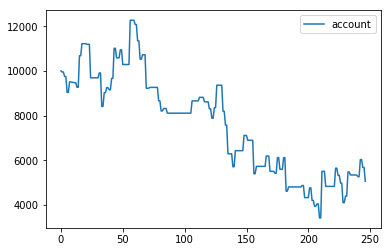

In [57]:
gold_account = get_performance(gold_clf, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, xgb_use=True, stop_loss=1500)
gold_account.plot()

In [58]:
gold_validate.head(10)

,0,1,2,3,4,5,6,7,8,9,...,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044
2018-01-02,1060.6,1062.7,1056.5,1060.2,53625.0,280974.0,1061.5,1083.0,1061.0,1075.2,...,0.336508,0.407006,0.357792,0.348020,0.431198,1,2,1,0,5.237515
2018-01-03,1061.5,1083.0,1061.0,1075.2,151922.0,279966.0,1073.5,1081.5,1071.9,1078.4,...,0.357792,0.348020,0.431198,0.243475,0.553172,2,3,1,0,5.576208
2018-01-04,1073.5,1081.5,1071.9,1078.4,99374.0,272926.0,1076.8,1094.9,1074.4,1091.9,...,0.357792,0.348020,0.431198,0.243475,0.553172,3,4,1,0,7.651007
2018-01-05,1076.8,1094.9,1074.4,1091.9,180313.0,272995.0,1093.7,1109.9,1091.1,1107.8,...,0.357792,0.348020,0.431198,0.243475,0.553172,4,5,1,0,6.934813
2018-01-08,1093.7,1109.9,1091.1,1107.8,203931.0,275025.0,1108.8,1113.1,1091.8,1097.9,...,0.357792,0.348020,0.431198,0.243475,0.553172,0,6,1,0,9.583333
2018-01-09,1108.8,1113.1,1091.8,1097.9,184682.0,271905.0,1103.6,1108.3,1093.1,1096.2,...,0.357792,0.348020,0.431198,0.243475,0.553172,1,7,1,0,20.923077
2018-01-10,1103.6,1108.3,1093.1,1096.2,187087.0,261337.0,1094.0,1099.1,1083.1,1085.2,...,0.431198,0.243475,0.553172,0.108704,0.689248,2,8,1,0,14.485981
2018-01-11,1094.0,1099.1,1083.1,1085.2,162076.0,240538.0,1086.8,1095.6,1079.4,1087.1,...,0.431198,0.243475,0.553172,0.108704,0.689248,3,9,1,0,9.744409
2018-01-12,1086.8,1095.6,1079.4,1087.1,148184.0,227953.0,1093.6,1095.4,1071.1,1073.6,...,0.431198,0.243475,0.553172,0.108704,0.689248,4,10,1,0,7.122905
2018-01-16,1093.6,1095.4,1071.1,1073.6,169528.0,223200.0,1079.2,1097.5,1076.0,1090.7,...,0.431198,0.243475,0.553172,0.108704,0.689248,1,12,1,0,11.738484


In [59]:
gold_gains.loc[gold_gains.index > '2016-01-01'].head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2016-01-04,465.5,107350.0,108150.0,107190.0,107840.0,1.0
2016-01-05,1434.5,107680.0,109490.0,107440.0,109190.0,1.0
2016-01-06,1339.5,109370.0,110990.0,109110.0,110780.0,1.0
2016-01-07,-1035.5,110880.0,111310.0,109180.0,109790.0,-1.0
2016-01-08,-703.0,110360.0,110830.0,109310.0,109620.0,-1.0
2016-01-11,-836.0,109400.0,109910.0,108310.0,108520.0,-1.0
2016-01-12,28.5,108680.0,109560.0,107940.0,108710.0,0.0
2016-01-13,-1900.0,109360.0,109540.0,107110.0,107360.0,-1.0
2016-01-14,1092.5,107920.0,109750.0,107600.0,109070.0,1.0


Long  1 0.0
Long  1 0.0
Short  -1 0.0
Short  -1 0.0
Short  -1 0.0
Short  -1 -1.0
Short  -1 0.0
Short  -1 1.0
Short  -1 1.0
short stop loss hit
Short  -1 1.0
Short  -1 0.0
Short  -1 -1.0
Short  -1 0.0
short stop loss hit
Short  -1 0.0
Short  -1 0.0
Short  -1 1.0
short stop loss hit
Short  -1 0.0
Short  -1 -1.0
Long  1 0.0
long stop loss hit
Long  1 0.0
Long  1 1.0
Long  1 0.0
Long  1 0.0
Short  -1 -1.0
Long  1 1.0
Short  -1 1.0
Short  -1 0.0
Short  -1 -1.0
Long  1 0.0
Short  -1 1.0
Short  -1 0.0
Short  -1 1.0
short stop loss hit


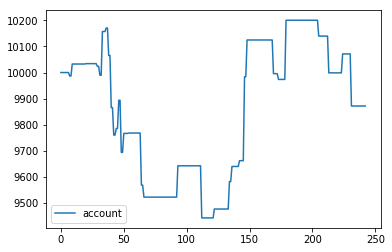

In [63]:
corn_account = get_performance(corn_clf, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, xgb_use=corn_xgb_use, stop_loss=200)
corn_account.plot()

Long  1 -1.0
long stop loss hit
Long  1 -1.0
long stop loss hit
Long  1 0.0
Long  1 0.0
Short  -1 0.0
Short  -1 -1.0
Short  -1 0.0
Long  1 0.0
Long  1 0.0
Long  1 0.0
Long  1 1.0
Long  1 -1.0
Long  1 0.0
Short  -1 -1.0
Short  -1 1.0
short stop loss hit
Short  -1 0.0
Long  1 -1.0
Short  -1 1.0
short stop loss hit
Short  -1 -1.0
Short  -1 0.0
Long  1 1.0
Short  -1 -1.0
Short  -1 1.0
Short  -1 -1.0
Short  -1 -1.0
Short  -1 0.0
Short  -1 -1.0
Short  -1 0.0
Short  -1 1.0
Short  -1 -1.0


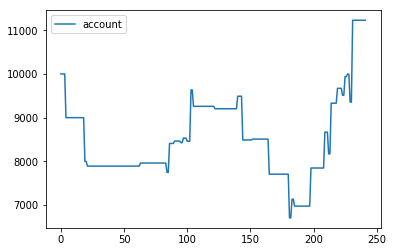

In [61]:
coffee_account = get_performance(coffee_clf, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, xgb_use=True, stop_loss=1000)
coffee_account.plot()